In [1]:
!pip install --upgrade pandas pyarrow
!pip install --upgrade matplotlib seaborn missingno numexpr bottleneck



[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import re
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
import missingno as msno 
import json
import os 
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression




np.random.seed(42) 


In [3]:
UTSG_DATA = pd.read_csv('DATA/UTSG_ML_data_food.csv')
UTM_DATA = pd.read_csv('DATA/UTM_ML_data_food.csv')
UTSG_DATA.insert(0, "campus", 'UTSG')
UTM_DATA.insert(0, "campus", 'UTM')
from sklearn.model_selection import train_test_split

# frames = [UTSG_DATA,UTM_DATA]
# data = pd.concat(frames)


In [4]:

def standardize_response_col_names(dataset):
    title = 'Answer the following questions about the food item:'
    new_cols = []
    cols_to_drop = []
    current_food = None
    
    for i, col in enumerate(dataset.columns):
        if title in str(col):
            current_food = col.split(':')[2].strip()
            cols_to_drop.append(col)  
        elif current_food and ':' in str(col):
            question = col.split(':', 1)[1].strip()
            new_cols.append(f"{current_food} {question}")
        else:
            new_cols.append(col)
    
    dataset = dataset.drop(columns=cols_to_drop)
    dataset.columns = new_cols
    
    return dataset

def clean_cols(dataset):
    cols_to_drop = [col for col in dataset.columns if '0.' in str(col)] + ['1.0', '0']
    data_dropped = dataset.drop(columns=cols_to_drop, errors='ignore')
    dataset = standardize_response_col_names(data_dropped)
    return dataset

def reshape_food_data(data_set):
    """
    Reshape dataframe from wide to long format.
    Each row is split into 3 rows (one for Pizza, Shawarma, and Sushi).
    """
    base_cols = [
        'From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
        'How many ingredients would you expect this food item to contain?',
        'In what setting would you expect this food to be served? Please check all that apply',
        'How much would you expect to pay for one serving of this food item?',
        'What movie do you think of when thinking of this food item?',
        'What drink would you pair with this food item?',
        'When you think about this food item, who does it remind you of?',
        'How much hot sauce would you add to this food item?'
    ]
    
    new_rows = []
    
    for idx, row in data_set.iterrows():
        pizza_data = {'ID': row['ID'], 'Food': 'Pizza'}
        for col in base_cols:
            pizza_data[col] = row[f'Pizza {col}']
        pizza_data['n correct'] = row['n correct']
        pizza_data['n incorrect'] = row['n incorrect']
        pizza_data['score'] = row['score']
        new_rows.append(pizza_data)
        
        shawarma_data = {'ID': row['ID'], 'Food': 'Shawarma'}
        for col in base_cols:
            shawarma_data[col] = row[f'Shawarma {col}']
        shawarma_data['n correct'] = row['n correct']
        shawarma_data['n incorrect'] = row['n incorrect']
        shawarma_data['score'] = row['score']
        new_rows.append(shawarma_data)
        
        sushi_data = {'ID': row['ID'], 'Food': 'Sushi'}
        for col in base_cols:
            sushi_data[col] = row[f'Sushi {col}']
        sushi_data['n correct'] = row['n correct']
        sushi_data['n incorrect'] = row['n incorrect']
        sushi_data['score'] = row['score']
        new_rows.append(sushi_data)
    
    data_set_split = pd.DataFrame(new_rows)
    
    return data_set_split


def parse_ingredient_count(value):

    # Deal with missing value 
    if pd.isna(value):
        return None, None, None
    
    value_str = str(value).strip()
    original = value_str
    
    # Word to number mapping
    word_to_num = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
        'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
        'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15,
        'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 'twenty': 20
    }
    
    value_lower = value_str.lower()
    
    # remove unused symbol
    value_cleaned = value_str.replace('~', '').strip()
    
    # Best case: First just attempt to get the lone value
    try:
        count = float(value_str)
        return count, count, count
    except:
        pass

    # Harder cases
    # Find "to" ranges like e.g. "3 to 7"
    to_range_match = re.search(r'(\d+)\s+to\s+(\d+)', value_cleaned)
    if to_range_match:
        num1 = float(to_range_match.group(1)) #lower bound
        num2 = float(to_range_match.group(2)) #upper bound
        min_count = min(num1, num2)
        max_count = max(num1, num2)
        avg_count = (min_count + max_count) / 2
        return min_count, max_count, avg_count
    
    # Find ranges with dash e.g. "6-8"
    dash_range_match = re.search(r'(\d+)\s*-\s*(\d+)', value_cleaned)
    if dash_range_match:
        num1 = float(dash_range_match.group(1)) #lower bound
        num2 = float(dash_range_match.group(2)) #upper bound
        min_count = min(num1, num2)
        max_count = max(num1, num2)
        avg_count = (min_count + max_count) / 2
        return min_count, max_count, avg_count
    
    # Find "at least X" pattern
    at_least_match = re.search(r'at least\s+(\d+)', value_lower)
    if at_least_match:
        count = float(at_least_match.group(1))
        return count, count, count
    # Find "about/around X" pattern (treat as exact)
    about_match = re.search(r'(?:about|around|approximately)\s+(\d+)', value_lower)
    if about_match:
        count = float(about_match.group(1))
        return count, count, count
    
    # Find "X:<ingredient list>" pattern
    colon_match = re.search(r'^(\d+)\s*:', value_cleaned)
    if colon_match:
        count = float(colon_match.group(1))
        return count, count, count
    
    # Check for word numbers like "about three"
    for word, num in word_to_num.items():
        if word in value_lower:
            return float(num), float(num), float(num)
    
    # Count bullet point lists (markdown lists with * or -)
    bullet_matches = re.findall(r'^\s*[\*\-•]\s+.+', value_str, re.MULTILINE)
    if len(bullet_matches) > 0:
        count = float(len(bullet_matches))
        return count, count, count
    
    # Edge cases surrounded by junk text
    lines = value_str.split('\n')
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Filter out header/intro lines
    ingredient_lines = []
    skip_patterns = [
        r'^i would expect',
        r'^it (would|should|might|could) (contain|have|include)',
        r'^\d+\s*:?\s*$',  # Just a number
    ]
    
    for line in cleaned_lines:
        line_lower = line.lower()
        if any(re.match(pattern, line_lower) for pattern in skip_patterns):
            continue
        ingredient_lines.append(line)
    
    # If we have multiple ingredient lines, count them
    if len(ingredient_lines) >= 2:
        count = float(len(ingredient_lines))
        return count, count, count
    
    # If we have exactly 1 ingredient line and there was a newline in original
    if len(ingredient_lines) == 1 and '\n' in value_str:
        return 1.0, 1.0, 1.0
    
    # Count commas in ingredient list
    if ',' in value_str:
        items = [item.strip() for item in value_str.split(',') if item.strip()]
        ingredient_items = [item for item in items if len(item) >= 2]
        if len(ingredient_items) > 1:
            count = float(len(ingredient_items))
            return count, count, count
    # Single word/phrase ingredient
    if '\n' not in value_str and len(value_str.split()) <= 4 and not any(char.isdigit() for char in value_str):
        return 1.0, 1.0, 1.0
    
    # Extract any number found in the string as last resort
    numbers = re.findall(r'\d+', value_str)
    if numbers:
        count = float(numbers[0])
        return count, count, count,
    
    return None, None, None


def apply_ingredient_parsing(df):
    column_name = 'How many ingredients would you expect this food item to contain?'
    results = df[column_name].apply(parse_ingredient_count)
    df[f'{column_name} (min)'] = results.apply(lambda x: x[0])
    df[f'{column_name} (max)'] = results.apply(lambda x: x[1])
    df['ingredient_count'] = results.apply(lambda x: x[2])

    
    return df



In [5]:
# canonicalizing movies 


def clean_text_for_matching(text):
    """Clean text for matching"""
    if pd.isna(text):
        return ''
    
    text = str(text).lower().strip()
    
    # Normalize all apostrophes to straight apostrophe FIRST
    text = text.replace(''', '\'').replace(''', '\'')
    
    # Remove quotation marks (both single and double) but NOT apostrophes
    text = text.replace('"', '').replace('"', '').replace('"', '')
    
    # Remove special whitespace characters
    text = re.sub(r'[\xa0\u200b\u200c\u200d\ufeff]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove common filler words at start
    text = re.sub(r'^(i think of |thinking of |reminds me of |the movie |movie |film )', '', text)
    
    # Remove punctuation at the end
    text = re.sub(r'[.,;!?]+$', '', text)
    
    return text.strip()


def map_to_canonical_movie(text, movie_mapping):
    """
    Map input text to a canonical movie title.
    """
    if pd.isna(text):
        return np.nan
    
    cleaned_text = clean_text_for_matching(text)
    
    if not cleaned_text:
        return np.nan
 
    # Try to match against canonical titles and their variations
    best_match = None
    longest_match_len = 0
    
    for canonical_title, variations in movie_mapping.items():
        for variation in variations:
            if len(variation) <= 2:
                pattern = r'\b' + re.escape(variation) + r'\b'
                if re.search(pattern, cleaned_text):
                    if len(variation) > longest_match_len:
                        longest_match_len = len(variation)
                        best_match = canonical_title
            else:
                if variation in cleaned_text:
                    if len(variation) > longest_match_len:
                        longest_match_len = len(variation)
                        best_match = canonical_title
    
    return best_match if best_match else np.nan


def apply_movie_mapping(df, column_name, output_column='movie_canonical', mapping_file='movie_mapping.json'):

    # Load movie mapping from JSON
    with open(mapping_file, 'r', encoding='utf-8') as f:
        movie_mapping = json.load(f)
    
    # Apply mapping
    df[output_column] = df[column_name].apply(
        lambda x: map_to_canonical_movie(x, movie_mapping)
    )
    

    
    
    return df


def simplified_movie_parse(f, column_name, output_column='movie_canonical'):
    #TODO:
    pass 
    

def create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie'):

    # Get one-hot encoding exclude NaN from being a col
    one_hot = pd.get_dummies(df[movie_column], prefix=prefix, dummy_na=False)
    
    # Convert boolean to int 1/0 
    one_hot = one_hot.astype(int)
    
    # add one hot vectors
    df = pd.concat([df, one_hot], axis=1)
    

    
    return df


In [6]:

def extract_price_smart(value):
    """Extract price intelligently, prioritizing numbers near $ or price keywords"""
    if pd.isna(value):
        return pd.Series({'min_price': None, 'max_price': None, 'avg_price': None})
    
    value_str = str(value).strip()
    
    # Look for numbers adjacent to $ symbol
    dollar_pattern = r'\$\s*(\d+\.?\d*)\s*-?\s*\$?\s*(\d+\.?\d*)?'
    dollar_matches = re.findall(dollar_pattern, value_str)
    
    if dollar_matches:
        # Found $ sign with numbers
        nums = [float(n) for match in dollar_matches for n in match if n]
        if len(nums) == 1:
            return pd.Series({'min_price': nums[0], 'max_price': nums[0], 'avg_price': nums[0]})
        else:
            min_p = min(nums[0], nums[1])
            max_p = max(nums[0], nums[1])
            return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})
    
    # Look for price keywords followed by numbers
    value_lower = value_str.lower()
    price_keywords = ['price', 'cost', 'costs', 'dollars', 'dollar', '~', 'around', 'approximately']
    
    for keyword in price_keywords:
        if keyword in value_lower:
            # Extract numbers after the keyword
            keyword_pos = value_lower.find(keyword)
            after_keyword = value_str[keyword_pos:]
            numbers = re.findall(r'\d+\.?\d*', after_keyword)
            numbers = [float(n) for n in numbers if float(n) < 1000]
            
            if numbers:
                if len(numbers) == 1:
                    return pd.Series({'min_price': numbers[0], 'max_price': numbers[0], 'avg_price': numbers[0]})
                else:
                    min_p = min(numbers[0], numbers[1])
                    max_p = max(numbers[0], numbers[1])
                    return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})
    
    # extract all numbers and filter by reasonable price range
    all_numbers = re.findall(r'\d+\.?\d*', value_str)
    all_numbers = [float(n) for n in all_numbers]
    
    # Filter to reasonable price range (between 0.5 and 500)
    price_numbers = [n for n in all_numbers if 0.5 <= n <= 500]
    
    if not price_numbers:
        # If no reasonable prices, return all numbers
        price_numbers = all_numbers
    
    if len(price_numbers) == 0:
        return pd.Series({'min_price': None, 'max_price': None, 'avg_price': None})
    elif len(price_numbers) == 1:
        return pd.Series({'min_price': price_numbers[0], 'max_price': price_numbers[0], 'avg_price': price_numbers[0]})
    else:
        # Take last one or two numbers (heuristic usually price comes at the end) 
        relevant = price_numbers[-2:] if len(price_numbers) >= 2 else price_numbers
        min_p = min(relevant)
        max_p = max(relevant)
        return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})



In [7]:
utsg_data_cleaned = clean_cols(UTSG_DATA) 
utm_data_cleaned = clean_cols(UTM_DATA) 

frames = [utsg_data_cleaned,utm_data_cleaned]
data = pd.concat(frames)
data = data.drop(data.columns[0:9], axis=1) 
data.insert(0, 'ID', range(len(data)))
data.columns


Index(['ID',
       'Pizza From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'Pizza How many ingredients would you expect this food item to contain?',
       'Pizza In what setting would you expect this food to be served? Please check all that apply',
       'Pizza How much would you expect to pay for one serving of this food item?',
       'Pizza What movie do you think of when thinking of this food item?',
       'Pizza What drink would you pair with this food item?',
       'Pizza When you think about this food item, who does it remind you of?',
       'Pizza How much hot sauce would you add to this food item?',
       'Shawarma From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'Shawarma How many ingredients would you expect this food item to contain?',
       'Shawarma In what setting would you expect this food to be served? Please check 

In [8]:
# Split dataset before splitting into different classes to prevent data leakage 
# 80/10/10 split
train_val_sets, test_set = train_test_split(
    data, 
    test_size=0.1,          
    random_state=42,
)
train_set, val_set = train_test_split(
    train_val_sets,
    test_size=0.111,           
    random_state=42,
)


In [9]:
train_set.describe

<bound method NDFrame.describe of       ID  \
68   293   
160  385   
237  462   
222  447   
67   292   
..   ...   
23    23   
127  127   
154  379   
188  413   
195  420   

     Pizza From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)  \
68                                                 3.0                                                                         
160                                                3.0                                                                         
237                                                1.0                                                                         
222                                                2.0                                                                         
67                                                 3.0                                                                         
..                                                 ..

In [10]:
data_reshaped = reshape_food_data(train_set)

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{data_reshaped.to_html(index=False)}
</div>
"""))

ID,Food,"From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",How many ingredients would you expect this food item to contain?,In what setting would you expect this food to be served? Please check all that apply,How much would you expect to pay for one serving of this food item?,What movie do you think of when thinking of this food item?,What drink would you pair with this food item?,"When you think about this food item, who does it remind you of?",How much hot sauce would you add to this food item?,n correct,n incorrect,score
293,Pizza,3.0,"A minimum of 3 but there can be more, up to 7 usually.","Week day lunch,Weekend lunch,At a party,Late night snack",Around 3-5 dollars depending on the quality.,"Monsters, Inc.",Soda.,"Parents,Friends,Teachers",NaN,17,10,1.0
293,Shawarma,2.0,3,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner,Late night snack",8-10 dollars.,The Avengers,Water.,"Parents,Siblings",A moderate amount (medium),17,10,1.0
293,Sushi,4.0,5-7.,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner,At a party",10 dollars.,Howl's Moving Castle,Water,Friends,NaN,17,10,1.0
385,Pizza,3.0,4,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner,At a party,Late night snack",$5.00,Teenage Mutant Ninja Turtles,Pop/Soda,"Siblings,Friends",NaN,16,11,1.0
385,Shawarma,4.0,5,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner",$10.00,The Avengers,Pop/Soda,"Parents,Siblings,Friends",A moderate amount (medium),16,11,1.0
385,Sushi,4.0,5,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner,Late night snack",$6.00,Turning Red,Water,"Siblings,Friends",A little (mild),16,11,1.0
462,Pizza,1.0,5-6 ingredients,"Weekend dinner,At a party",15-20,spaghetti with a chance of meatballs,coke zero,"Friends,Strangers",NaN,19,8,1.0
462,Shawarma,3.0,10,Week day lunch,10-12,The avengers,Coke zero,Friends,A moderate amount (medium),19,8,1.0
462,Sushi,2.0,On average 2-4,"Week day lunch,Week day dinner,Weekend lunch,Weekend dinner",6,Bullet train,Barley tea\n----------,Friends,NaN,19,8,1.0
447,Pizza,2.0,I would expect this food to contain 4-6 ingredients.,"Week day lunch,Weekend lunch,At a party,Late night snack",I would expect to pay 5$ for one serving.,"I think of Italian mobster movies, like the Godfather.","Iced tea, or soda.","Parents,Friends",NaN,19,8,1.0


In [11]:
data_reshaped.columns

Index(['ID', 'Food',
       'From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?', 'n correct',
       'n incorrect', 'score'],
      dtype='str')

In [12]:
X_train = data_reshaped.drop(data_reshaped.columns[[0,1,10,11,12]], axis=1)
y_train = data_reshaped['Food']  

In [13]:
df = apply_ingredient_parsing(X_train)
parse_check = df[[
    'How many ingredients would you expect this food item to contain?',
    'How many ingredients would you expect this food item to contain? (min)',
    'How many ingredients would you expect this food item to contain? (max)',
    'ingredient_count'
]]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html(index=False)}
</div>
"""))


How many ingredients would you expect this food item to contain?,How many ingredients would you expect this food item to contain? (min),How many ingredients would you expect this food item to contain? (max),ingredient_count
"A minimum of 3 but there can be more, up to 7 usually.",2.0,2.0,2.0
3,3.0,3.0,3.0
5-7.,5.0,7.0,6.0
4,4.0,4.0,4.0
5,5.0,5.0,5.0
5,5.0,5.0,5.0
5-6 ingredients,5.0,6.0,5.5
10,10.0,10.0,10.0
On average 2-4,2.0,4.0,3.0
I would expect this food to contain 4-6 ingredients.,4.0,6.0,5.0


In [14]:

df = apply_movie_mapping(
    df, 
    'What movie do you think of when thinking of this food item?',
    output_column='movie_canonical'
)



In [15]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical'],
      dtype='str')

In [16]:

parse_check = df[['What movie do you think of when thinking of this food item?', 'movie_canonical']]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
0,"Monsters, Inc.",monsters inc
1,The Avengers,avengers
2,Howl's Moving Castle,howl's moving castle
3,Teenage Mutant Ninja Turtles,teenage mutant ninja turtles
4,The Avengers,avengers
5,Turning Red,turning red
6,spaghetti with a chance of meatballs,cloudy with a chance of meatballs
7,The avengers,avengers
8,Bullet train,bullet train
9,"I think of Italian mobster movies, like the Godfather.",godfather


In [17]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
16,NaN,NaN
17,NaN,NaN
25,NaN,NaN
45,NaN,NaN
46,NaN,NaN
47,NaN,NaN
84,"any kind really, probably something more relaxed for leisure",NaN
86,Nothing,NaN
91,Probably some niche movie or some movie specific to a country and not an English movie.,NaN
105,no movie,NaN


In [18]:
# df.loc[215, 'movie_canonical'] = 'Liz and the Blue Bird	'
# df.loc[782, 'movie_canonical'] = 'Who am I?'
# df.loc[786, 'movie_canonical'] = 'documentary'
# df.loc[1351, 'movie_canonical'] = 'Ferris Bueller’s Day Off'
# df.loc[1520, 'movie_canonical'] = 'Kiki’s Delivery Service'
df.loc[708, 'movie_canonical'] = 'ratatouille'

In [19]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
16,NaN,NaN
17,NaN,NaN
25,NaN,NaN
45,NaN,NaN
46,NaN,NaN
47,NaN,NaN
84,"any kind really, probably something more relaxed for leisure",NaN
86,Nothing,NaN
91,Probably some niche movie or some movie specific to a country and not an English movie.,NaN
105,no movie,NaN


In [20]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical'],
      dtype='str')

In [21]:
# New version that just does vectors for the 30
top_10 = df['movie_canonical'].value_counts().head(10).index
df['movie_canonical'] = df['movie_canonical'].apply(
    lambda x: x if x in top_10 else np.nan
)
# Old version that creates one vector per movie
# df = create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie')
df = create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie')


In [22]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_avengers',
       'movie_cloudy with a chance of meatballs', 'movie_home alone',
       'movie_jiro dreams of sushi', 'movie_monsters inc', 'movie_rat

In [23]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))

,What movie do you think of when thinking of this food item?,movie_canonical
2,Howl's Moving Castle,NaN
5,Turning Red,NaN
8,Bullet train,NaN
9,"I think of Italian mobster movies, like the Godfather.",NaN
10,I think of the movie Borat.,NaN
11,I don't think of any movies. I think of anime.,NaN
12,Pirates of the Caribbean,NaN
13,Shrek,NaN
14,Barbie (2021),NaN
16,NaN,NaN


In [24]:
df['movie_avengers']

0       0
1       1
2       0
3       0
4       1
       ..
1219    1
1220    0
1221    0
1222    0
1223    0
Name: movie_avengers, Length: 1224, dtype: int64

In [25]:
df[['pay_min_price', 'pay_max_price', 'pay_avg_price']] = df['How much would you expect to pay for one serving of this food item?'].apply(extract_price_smart)

In [26]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))

,What movie do you think of when thinking of this food item?,movie_canonical
2,Howl's Moving Castle,NaN
5,Turning Red,NaN
8,Bullet train,NaN
9,"I think of Italian mobster movies, like the Godfather.",NaN
10,I think of the movie Borat.,NaN
11,I don't think of any movies. I think of anime.,NaN
12,Pirates of the Caribbean,NaN
13,Shrek,NaN
14,Barbie (2021),NaN
16,NaN,NaN


In [27]:
parse_check = df[
    ['How much would you expect to pay for one serving of this food item?', 
     'pay_min_price', 
     'pay_max_price', 
     'pay_avg_price']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,How much would you expect to pay for one serving of this food item?,pay_min_price,pay_max_price,pay_avg_price
0,Around 3-5 dollars depending on the quality.,3.00,5.00,4.000
1,8-10 dollars.,8.00,10.00,9.000
2,10 dollars.,10.00,10.00,10.000
3,$5.00,5.00,5.00,5.000
4,$10.00,10.00,10.00,10.000
5,$6.00,6.00,6.00,6.000
6,15-20,15.00,20.00,17.500
7,10-12,10.00,12.00,11.000
8,6,6.00,6.00,6.000
9,I would expect to pay 5$ for one serving.,5.00,5.00,5.000


In [28]:
hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
setting = df['In what setting would you expect this food to be served? Please check all that apply'].str.get_dummies(sep=',')
scale = df['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)']

In [29]:
remind

,Friends,Parents,Siblings,Strangers,Teachers
0,1,1,0,0,1
1,0,1,1,0,0
2,1,0,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
...,...,...,...,...,...
1219,1,0,0,0,0
1220,1,0,0,0,0
1221,1,0,0,0,0
1222,0,0,0,1,0


In [30]:
setting

,At a party,Late night snack,Week day dinner,Week day lunch,Weekend dinner,Weekend lunch
0,1,1,0,1,0,1
1,0,1,1,1,1,1
2,1,0,1,1,1,1
3,1,1,1,1,1,1
4,0,0,1,1,1,1
...,...,...,...,...,...,...
1219,1,0,0,1,0,1
1220,1,1,0,1,0,1
1221,1,0,1,1,1,1
1222,0,1,1,0,1,0


In [31]:
df.columns 

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_avengers',
       'movie_cloudy with a chance of meatballs', 'movie_home alone',
       'movie_jiro dreams of sushi', 'movie_monsters inc', 'movie_rat

In [32]:
df['How much hot sauce would you add to this food item?'].value_counts() #TODO: do more simple EDA with this


How much hot sauce would you add to this food item?
A little (mild)                                         272
A moderate amount (medium)                              264
A lot (hot)                                             109
I will have some of this food item with my hot sauce     18
Name: count, dtype: int64

In [33]:
# make one-hot vectors of all other option questions
hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
setting = df['In what setting would you expect this food to be served? Please check all that apply'].str.get_dummies(sep=',')

# scale col
scale = df['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)']

# Add prefixes to avoid column name conflicts
hot_sauce = hot_sauce.add_prefix('hot_sauce_')
remind = remind.add_prefix('remind_')
setting = setting.add_prefix('setting_')

# add all to the original dataFrame
df = pd.concat([df, hot_sauce, remind, setting], axis=1)

# Add the scale column (it's already a Series)
df['complexity_scale'] = scale





In [34]:
remind_cols = [col for col in df.columns if col.startswith('remind_')]
remind_cols

['remind_Friends',
 'remind_Parents',
 'remind_Siblings',
 'remind_Strangers',
 'remind_Teachers']

In [35]:
#FINAL PREDICTORS
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_avengers',
       'movie_cloudy with a chance of meatballs', 'movie_home alone',
       'movie_jiro dreams of sushi', 'movie_monsters inc', 'movie_rat

EDA BELOW

In [36]:
#GENERAL DATA SET EDA
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 41 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)  1221 non-null   float64
 1   How many ingredients would you expect this food item to contain?                                                   1221 non-null   str    
 2   In what setting would you expect this food to be served? Please check all that apply                               1221 non-null   str    
 3   How much would you expect to pay for one serving of this food item?                                                1221 non-null   str    
 4   What movie do you think of when thi

In [37]:
X_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 12 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)  1221 non-null   float64
 1   How many ingredients would you expect this food item to contain?                                                   1221 non-null   str    
 2   In what setting would you expect this food to be served? Please check all that apply                               1221 non-null   str    
 3   How much would you expect to pay for one serving of this food item?                                                1221 non-null   str    
 4   What movie do you think of when thi

In [38]:
#convert y_train series to dataframe convert back later
y_train_df = y_train.to_frame()


Food distribution:
Food
Pizza       408
Shawarma    408
Sushi       408
Name: count, dtype: int64


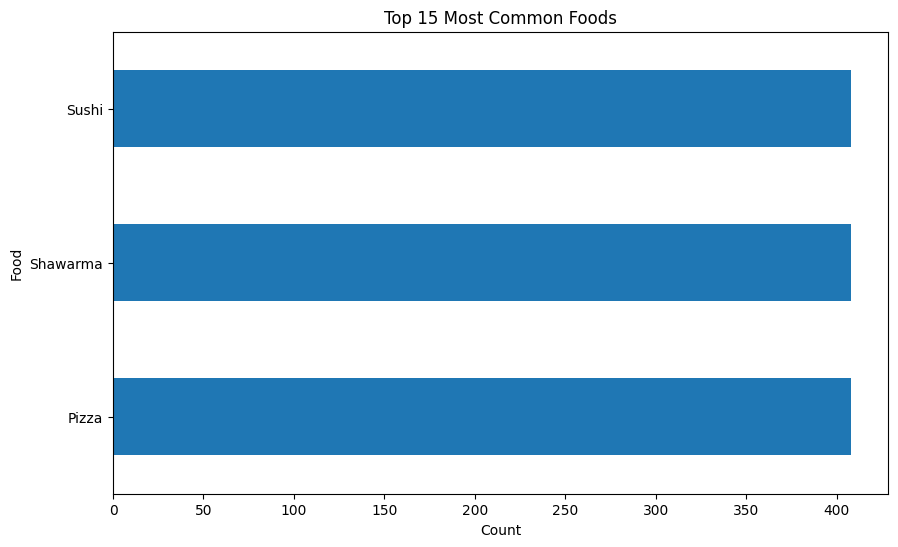


Total samples: 1224
Unique foods: 3

Most common: Pizza


In [39]:

# Distribution of food types
print("Food distribution:")
print(y_train.value_counts())

# Visualization
plt.figure(figsize=(10, 6))
y_train.value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Most Common Foods')
plt.xlabel('Count')
plt.show()

print(f"\nTotal samples: {len(y_train)}")
print(f"Unique foods: {y_train.nunique()}")
print(f"\nMost common: {y_train.mode()[0]}")

In [40]:
#TARGET VARIABLE EDA 
# TODO:
#logitisci regression
# split properly

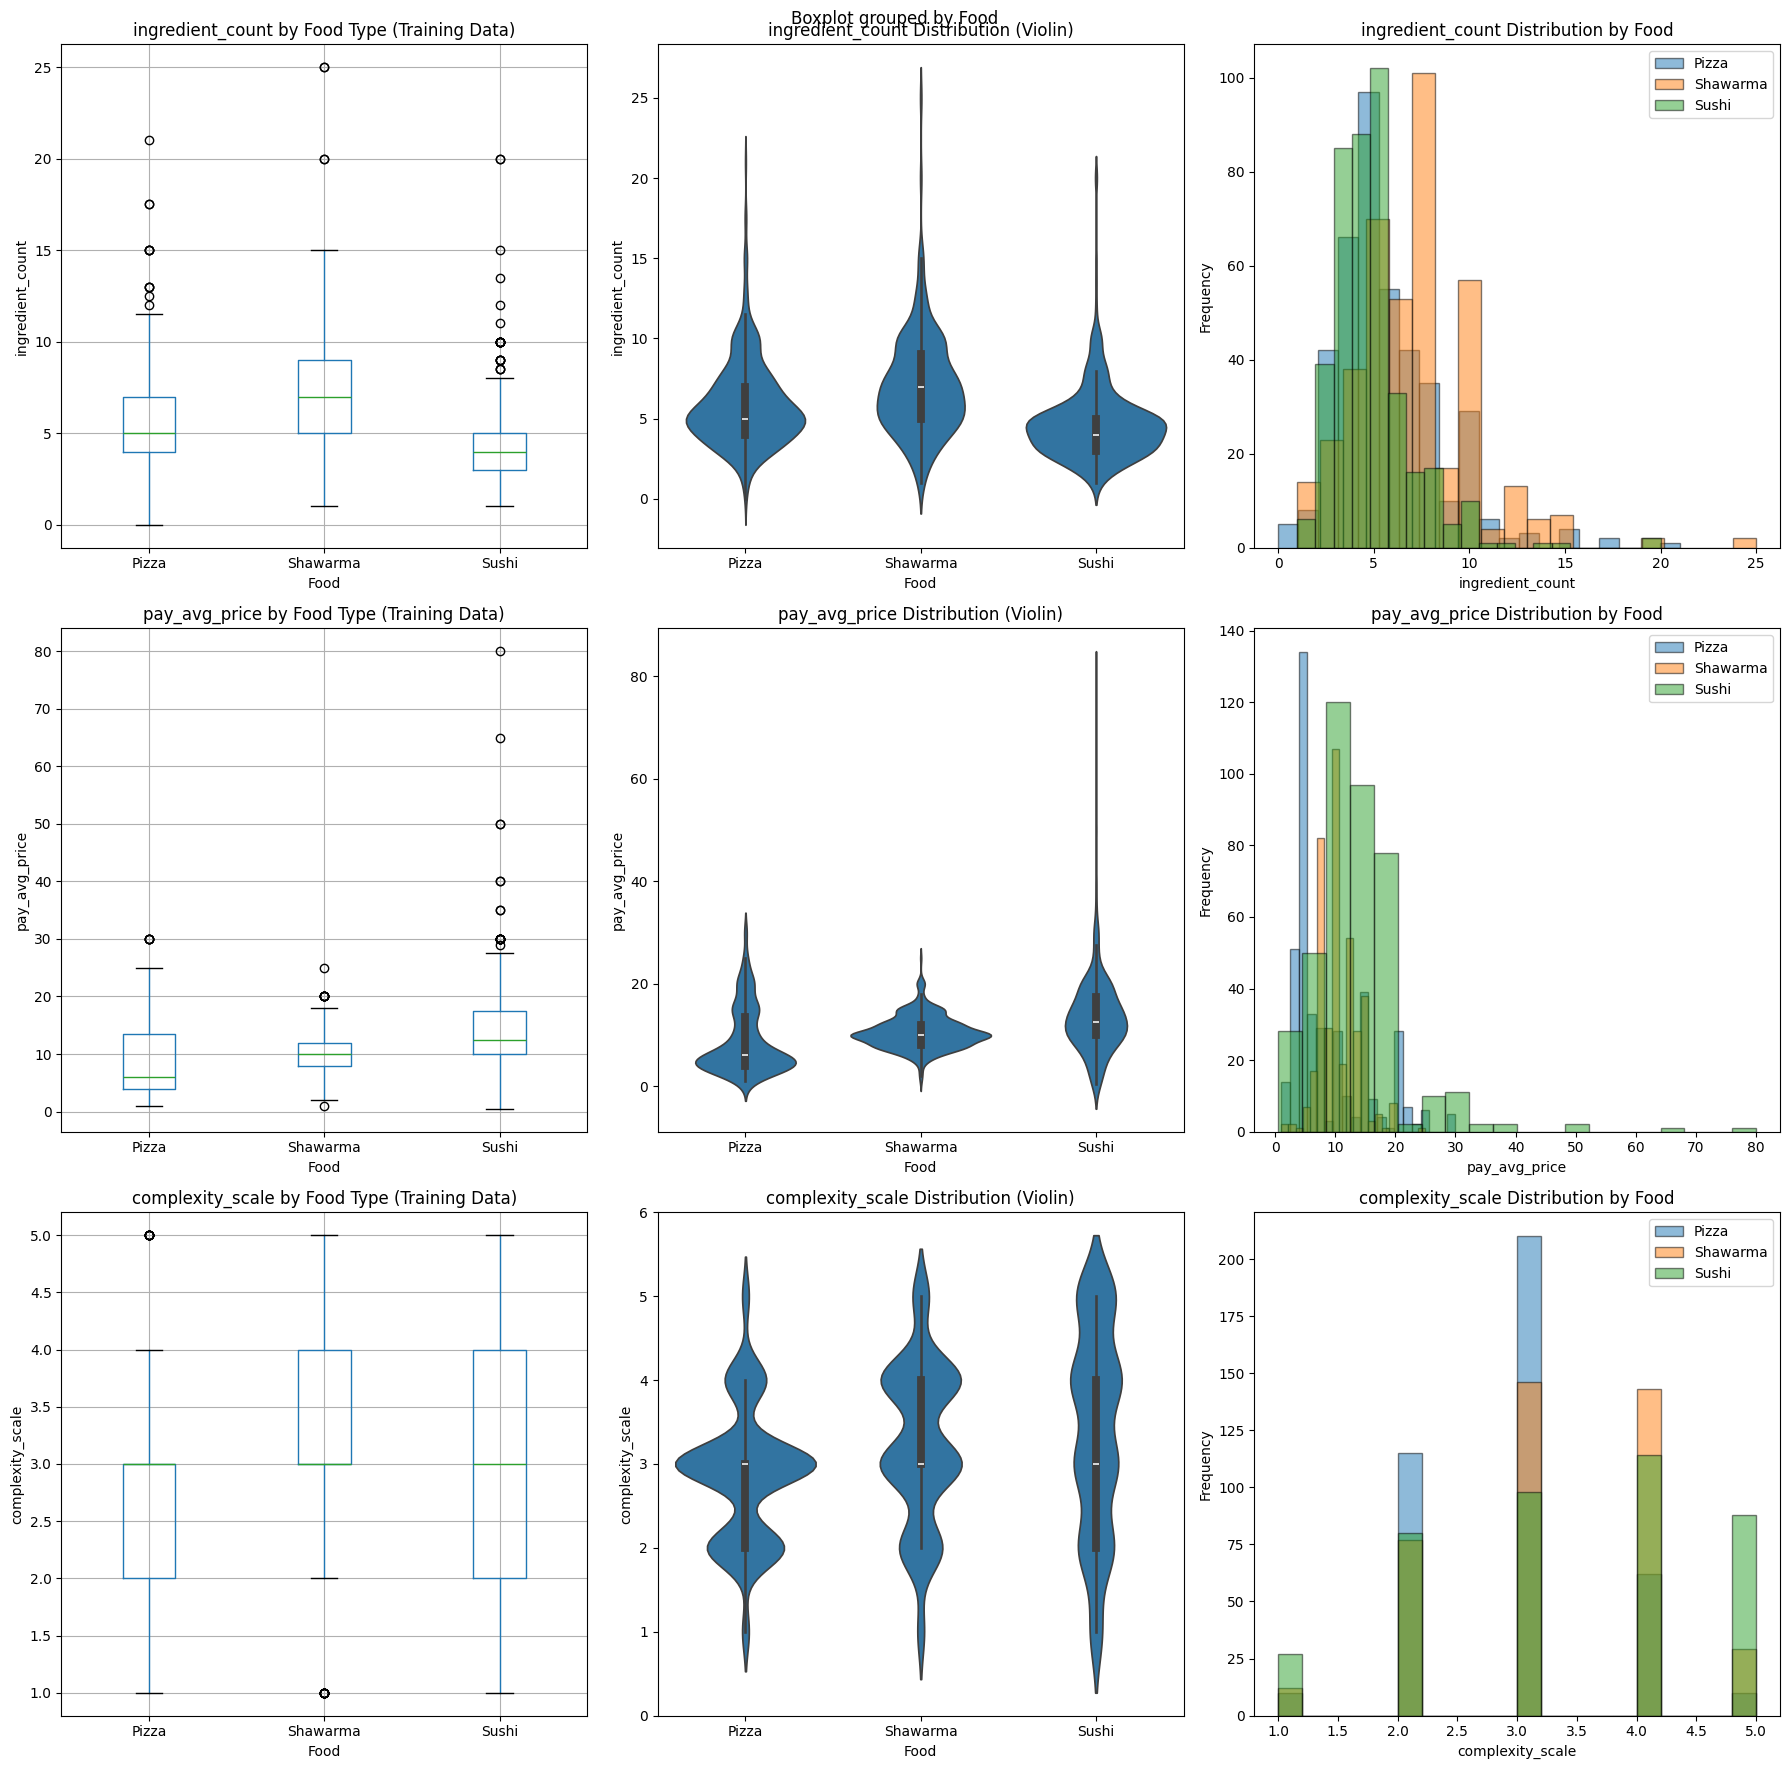

In [41]:
# Combine X_train and y_train back together
train_df = df.copy()
train_df['Food'] = y_train.values  # Add back the target

numerical_cols = ['ingredient_count', 'pay_avg_price', 'complexity_scale']

n_features = len(numerical_cols)
fig, axes = plt.subplots(n_features, 3, figsize=(18, 6*n_features))

if n_features == 1:
    axes = axes.reshape(1, -1)

for i, feature in enumerate(numerical_cols):
    # Box plot
    train_df.boxplot(column=feature, by='Food', ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} by Food Type (Training Data)')
    axes[i, 0].set_xlabel('Food')
    axes[i, 0].set_ylabel(feature)
    
    # Violin plot
    sns.violinplot(data=train_df, x='Food', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} Distribution (Violin)')
    axes[i, 1].set_xlabel('Food')
    
    # Counts 
    for food in train_df['Food'].unique():
        food_data = train_df[train_df['Food'] == food][feature].dropna()
        axes[i, 2].hist(food_data, bins=20, alpha=0.5, label=food, edgecolor='black')
    axes[i, 2].set_title(f'{feature} Distribution by Food')
    axes[i, 2].set_xlabel(feature)
    axes[i, 2].set_ylabel('Frequency')
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

In [42]:
# Find the movie one-hot columns
train_df.columns[12:22]

Index(['movie_avengers', 'movie_cloudy with a chance of meatballs',
       'movie_home alone', 'movie_jiro dreams of sushi', 'movie_monsters inc',
       'movie_ratatouille', 'movie_spider-man', 'movie_spider-man 2',
       'movie_spirited away', 'movie_teenage mutant ninja turtles'],
      dtype='str')

In [43]:
train_df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_avengers',
       'movie_cloudy with a chance of meatballs', 'movie_home alone',
       'movie_jiro dreams of sushi', 'movie_monsters inc', 'movie_rat

In [44]:
movie_cols = train_df.columns[12:22].tolist()
movie_cols

['movie_avengers',
 'movie_cloudy with a chance of meatballs',
 'movie_home alone',
 'movie_jiro dreams of sushi',
 'movie_monsters inc',
 'movie_ratatouille',
 'movie_spider-man',
 'movie_spider-man 2',
 'movie_spirited away',
 'movie_teenage mutant ninja turtles']


MOVIE FEATURES BY FOOD TYPE


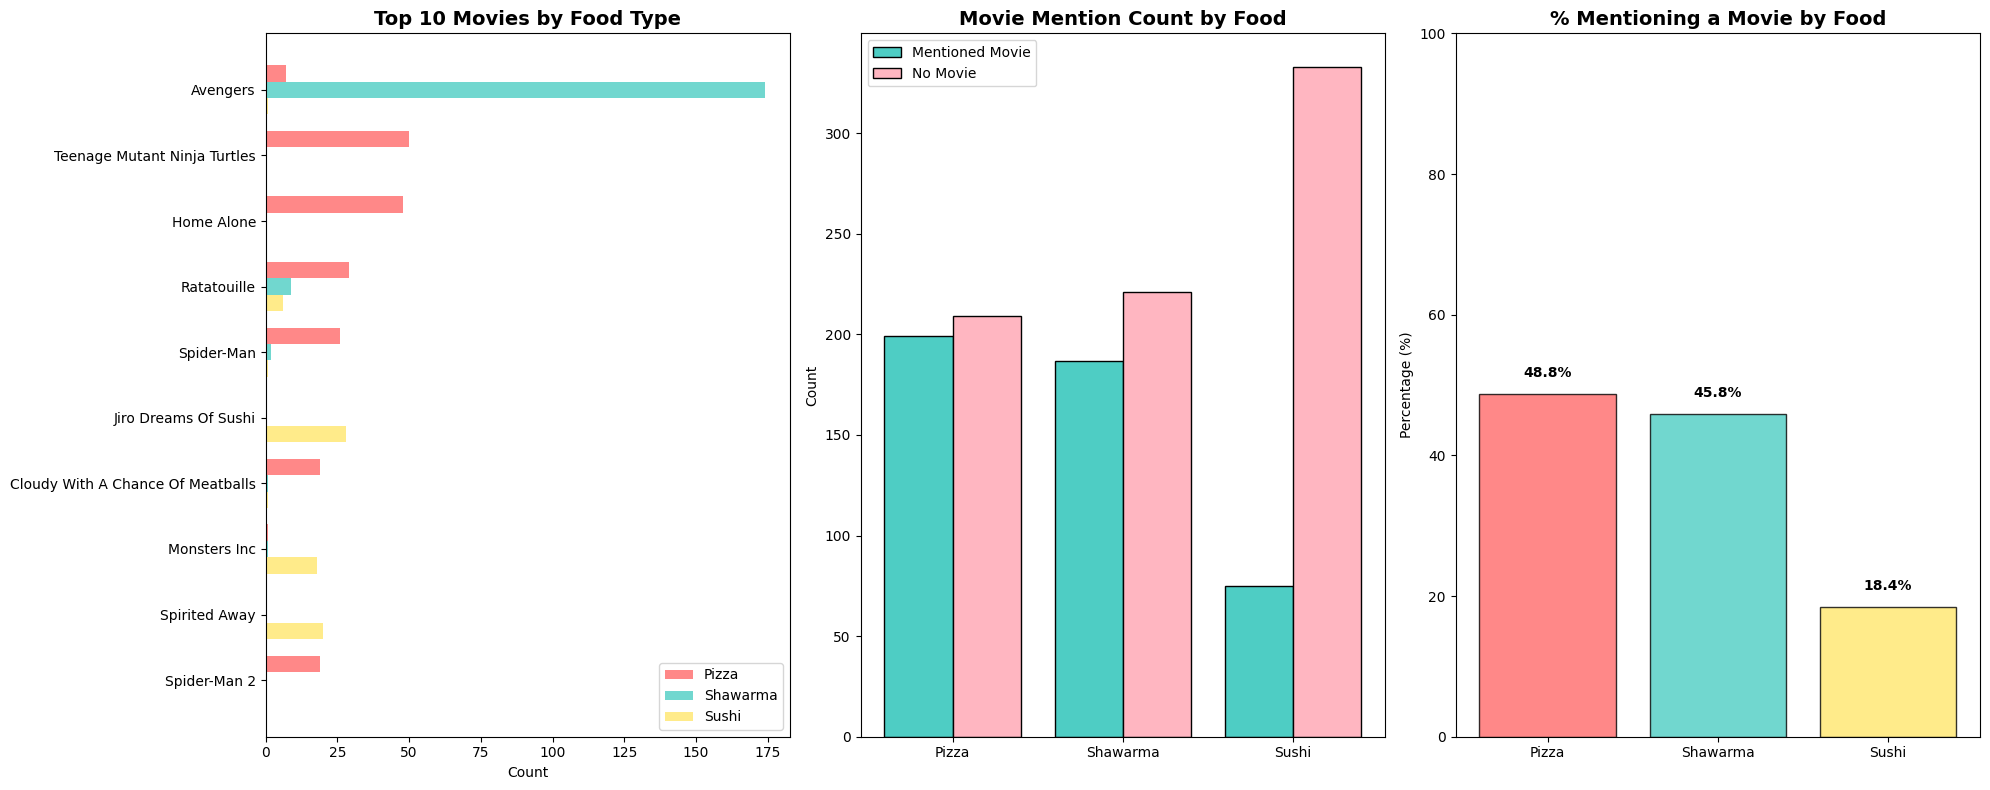


Movie Mention Rate by Food:
Food
Pizza       48.8
Shawarma    45.8
Sushi       18.4
Name: mentioned_movie, dtype: float64

Top 3 Movies per Food Type:

Pizza:
  Teenage Mutant Ninja Turtles: 50
  Home Alone: 48
  Ratatouille: 29

Shawarma:
  Avengers: 174
  Ratatouille: 9
  Spider-Man: 2

Sushi:
  Jiro Dreams Of Sushi: 28
  Spirited Away: 20
  Monsters Inc: 18


In [45]:


# Get movie columns
movie_cols = train_df.columns[12:22].tolist()

print("\n" + "="*70)
print("MOVIE FEATURES BY FOOD TYPE")
print("="*70)

# Create subplot structure: 1 row, 3 columns (like numerical features)
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot 1: Top movies per food (side by side bars)
food_types = train_df['Food'].unique()
colours = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Get top 10 movies overall
top_10_movies = train_df[movie_cols].sum().sort_values(ascending=False).head(10)
movie_names = [m.replace('movie_', '').replace('_', ' ').title() for m in top_10_movies.index]

# Plot grouped bar chart
x = np.arange(len(top_10_movies))
width = 0.25

for i, food in enumerate(food_types):
    food_df = train_df[train_df['Food'] == food]
    counts = [food_df[col].sum() for col in top_10_movies.index]
    axes[0].barh(x + i*width, counts, width, label=food, color=colours[i], alpha=0.8)

axes[0].set_yticks(x + width)
axes[0].set_yticklabels(movie_names)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 10 Movies by Food Type', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].invert_yaxis()

# Plot 2: Movie mention rate by food (like violin plot position)
train_df['mentioned_movie'] = train_df['movie_canonical'].notna().astype(int)

# Count mentioned vs not mentioned for each food
# Not Mentioned is all zeroes
mention_data = []
for food in food_types:
    food_df = train_df[train_df['Food'] == food]
    mention_data.append({
        'Food': food,
        'Mentioned': food_df['mentioned_movie'].sum(),
        'Not Mentioned': len(food_df) - food_df['mentioned_movie'].sum() 
    })

mention_df = pd.DataFrame(mention_data)

x_pos = np.arange(len(food_types))
axes[1].bar(x_pos - 0.2, mention_df['Mentioned'], 0.4, label='Mentioned Movie', 
            color='#4ECDC4', edgecolor='black')
axes[1].bar(x_pos + 0.2, mention_df['Not Mentioned'], 0.4, label='No Movie', 
            color='#FFB6C1', edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(food_types)
axes[1].set_ylabel('Count')
axes[1].set_title('Movie Mention Count by Food', fontsize=14, fontweight='bold')
axes[1].legend()

# Plot 3: Percentage mentioning movies (like histogram position)
mention_rate = train_df.groupby('Food')['mentioned_movie'].mean() * 100

axes[2].bar(range(len(mention_rate)), mention_rate.values, 
            color=colours, edgecolor='black', alpha=0.8)
axes[2].set_xticks(range(len(mention_rate)))
axes[2].set_xticklabels(mention_rate.index)
axes[2].set_ylabel('Percentage (%)')
axes[2].set_ylim(0, 100)
axes[2].set_title('% Mentioning a Movie by Food', fontsize=14, fontweight='bold')

# Add percentage labels on bars
for i, v in enumerate(mention_rate.values):
    axes[2].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nMovie Mention Rate by Food:")
print(mention_rate.round(1))

print("\nTop 3 Movies per Food Type:")
for food in food_types:
    food_df = train_df[train_df['Food'] == food]
    top_3 = food_df[movie_cols].sum().sort_values(ascending=False).head(3)
    print(f"\n{food}:")
    for movie, count in top_3.items():
        movie_name = movie.replace('movie_', '').replace('_', ' ').title()
        print(f"  {movie_name}: {int(count)}")



In [46]:
hot_sauce_cols = [col for col in train_df.columns if col.startswith('hot_sauce_')]
setting_cols = [col for col in train_df.columns if col.startswith('setting_')]

In [47]:
hot_sauce_cols

['hot_sauce_A little (mild)',
 'hot_sauce_A lot (hot)',
 'hot_sauce_A moderate amount (medium)',
 'hot_sauce_I will have some of this food item with my hot sauce']


CATEGORICAL FEATURES BY FOOD TYPE


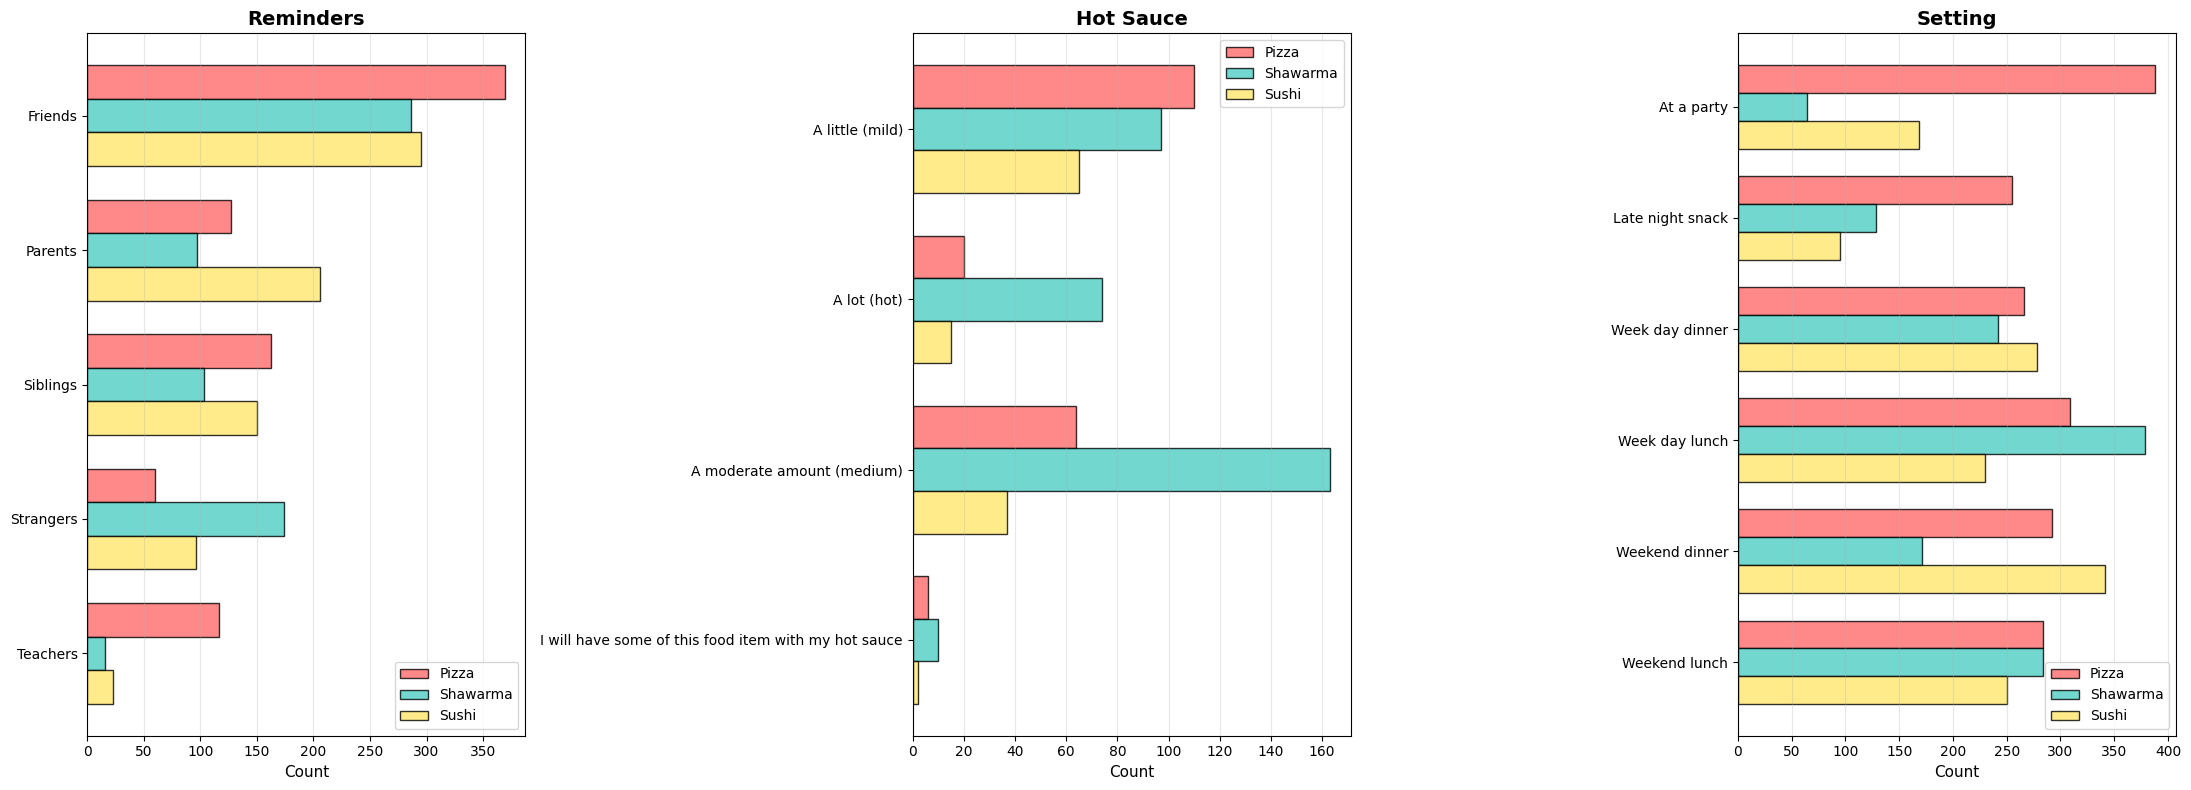


REMINDERS BREAKDOWN BY FOOD TYPE

Pizza:
  Friends: 369 (90.4%)
  Parents: 127 (31.1%)
  Siblings: 162 (39.7%)
  Strangers: 60 (14.7%)
  Teachers: 116 (28.4%)

Shawarma:
  Friends: 286 (70.1%)
  Parents: 97 (23.8%)
  Siblings: 103 (25.2%)
  Strangers: 174 (42.6%)
  Teachers: 16 (3.9%)

Sushi:
  Friends: 295 (72.3%)
  Parents: 206 (50.5%)
  Siblings: 150 (36.8%)
  Strangers: 96 (23.5%)
  Teachers: 23 (5.6%)

HOT SAUCE BREAKDOWN BY FOOD TYPE

Pizza:
  A little (mild): 110 (27.0%)
  A lot (hot): 20 (4.9%)
  A moderate amount (medium): 64 (15.7%)
  I will have some of this food item with my hot sauce: 6 (1.5%)

Shawarma:
  A little (mild): 97 (23.8%)
  A lot (hot): 74 (18.1%)
  A moderate amount (medium): 163 (40.0%)
  I will have some of this food item with my hot sauce: 10 (2.5%)

Sushi:
  A little (mild): 65 (15.9%)
  A lot (hot): 15 (3.7%)
  A moderate amount (medium): 37 (9.1%)
  I will have some of this food item with my hot sauce: 2 (0.5%)

SETTING BREAKDOWN BY FOOD TYPE

Pizza:
  

In [48]:
# Get the column groups
remind_cols = [col for col in train_df.columns if col.startswith('remind_')]
hot_sauce_cols = [col for col in train_df.columns if col.startswith('hot_sauce_')]
setting_cols = [col for col in train_df.columns if col.startswith('setting_')]

# Combine all column groups
all_col_groups = [
    ('Reminders', remind_cols),
    ('Hot Sauce', hot_sauce_cols),
    ('Setting', setting_cols)
]

print("\n" + "="*70)
print("CATEGORICAL FEATURES BY FOOD TYPE")
print("="*70)

# Convert all to numeric
for title, cols in all_col_groups:
    for col in cols:
        try:
            if pd.api.types.is_numeric_dtype(train_df[col]):
                train_df[col] = train_df[col].fillna(0).astype(int)
            else:
                train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)
        except Exception as e:
            print(f"Error converting {col}: {e}")

# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

food_types = train_df['Food'].unique()
colours = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Plot each category
for plot_idx, (title, cols) in enumerate(all_col_groups):
    if not cols:
        axes[plot_idx].text(0.5, 0.5, f'No {title} columns found', 
                           ha='center', va='center', fontsize=12)
        axes[plot_idx].set_title(title, fontsize=14, fontweight='bold')
        continue
    
    # Clean column names for display
    feature_names = [col.replace(f'{title.lower().replace(" ", "_")}_', '')
                    .replace('remind_', '')
                    .replace('hot_sauce_', '')
                    .replace('setting_', '')
                    for col in cols]
    
    x = np.arange(len(cols))
    width = 0.25
    
    # Plot bars for each food type
    for i, food in enumerate(food_types):
        food_df = train_df[train_df['Food'] == food]
        counts = [int(food_df[col].sum()) for col in cols]
        axes[plot_idx].barh(x + i*width, counts, width, label=food, 
                           color=colours[i], alpha=0.8, edgecolor='black')
    
    axes[plot_idx].set_yticks(x + width)
    axes[plot_idx].set_yticklabels(feature_names, fontsize=10)
    axes[plot_idx].set_xlabel('Count', fontsize=11)
    axes[plot_idx].set_title(title, fontsize=14, fontweight='bold')
    axes[plot_idx].legend()
    axes[plot_idx].invert_yaxis()
    axes[plot_idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print statistics for all three
for title, cols in all_col_groups:
    if not cols:
        continue
    
    print("\n" + "="*70)
    print(f"{title.upper()} BREAKDOWN BY FOOD TYPE")
    print("="*70)
    
    for food in food_types:
        food_df = train_df[train_df['Food'] == food]
        print(f"\n{food}:")
        for col in cols:
            count = int(food_df[col].sum())
            pct = (count / len(food_df) * 100)
            feature_name = col.replace('remind_', '').replace('hot_sauce_', '').replace('setting_', '')
            print(f"  {feature_name}: {count} ({pct:.1f}%)")

In [49]:
# hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
# remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
# setting 

Features with |r| >= 0.1: 18


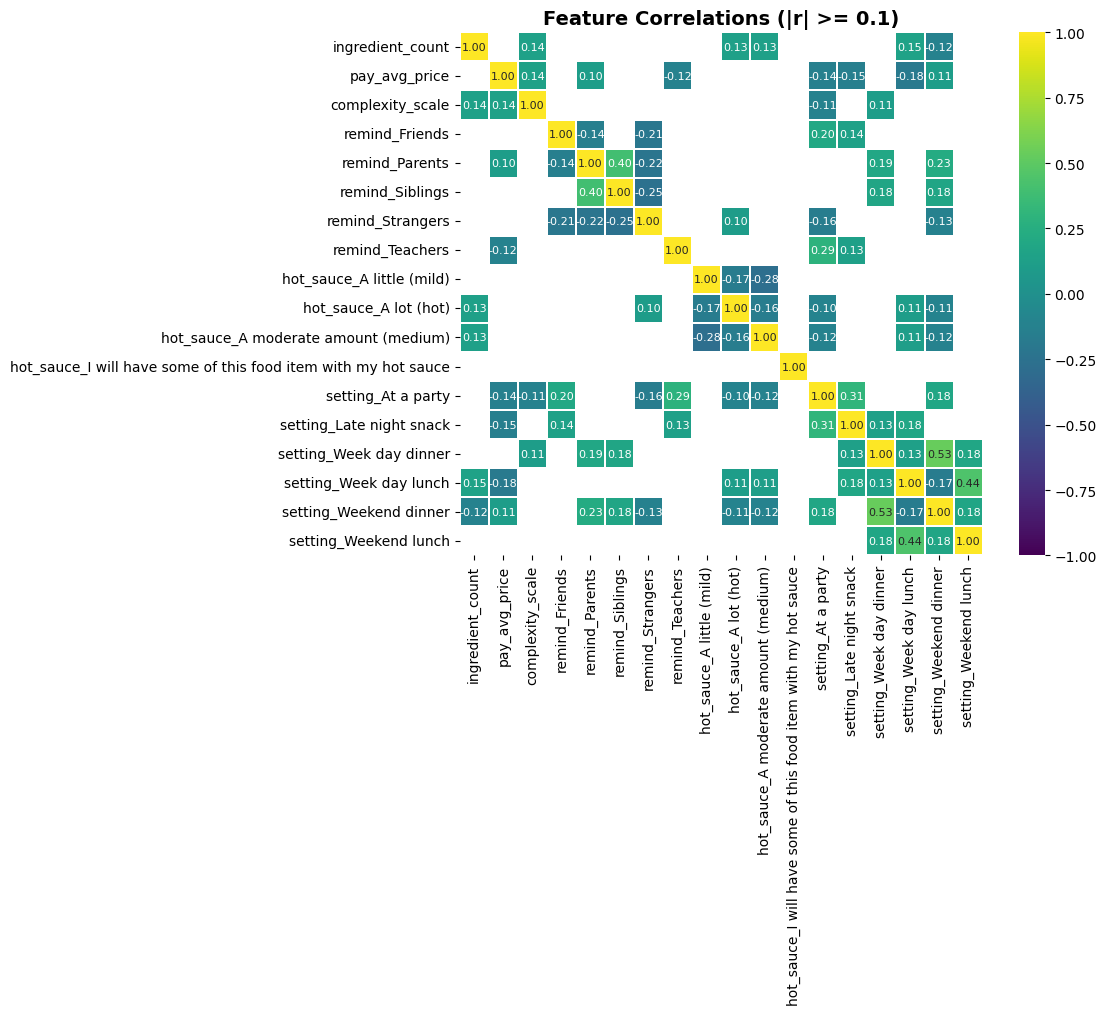

In [50]:
all_features = numerical_cols + remind_cols + hot_sauce_cols + setting_cols
corr = train_df[all_features].corr()

threshold = 0.1 

filtered_corr = corr[(corr >= threshold) | (corr <= -threshold)]
filtered_corr = filtered_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

print(f"Features with |r| >= {threshold}: {filtered_corr.shape[0]}")

if filtered_corr.shape[0] > 0:
    plt.figure(figsize=(max(12, filtered_corr.shape[0] * 0.5), 
                        max(10, filtered_corr.shape[1] * 0.5)))
    
    sns.heatmap(filtered_corr, 
                cmap='viridis', 
                vmax=1.0, 
                vmin=-1.0, 
                linewidths=0.1,
                annot=True, 
                annot_kws={"size": 8}, 
                square=True,
                fmt='.2f')
    
    plt.title(f'Feature Correlations (|r| >= {threshold})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"No correlations found with |r| >= {threshold}")
    print("Try an even lower threshold (e.g., 0.2)")

In [51]:
movie_cols

['movie_avengers',
 'movie_cloudy with a chance of meatballs',
 'movie_home alone',
 'movie_jiro dreams of sushi',
 'movie_monsters inc',
 'movie_ratatouille',
 'movie_spider-man',
 'movie_spider-man 2',
 'movie_spirited away',
 'movie_teenage mutant ninja turtles']

Features with |r| >= 0.1: 28


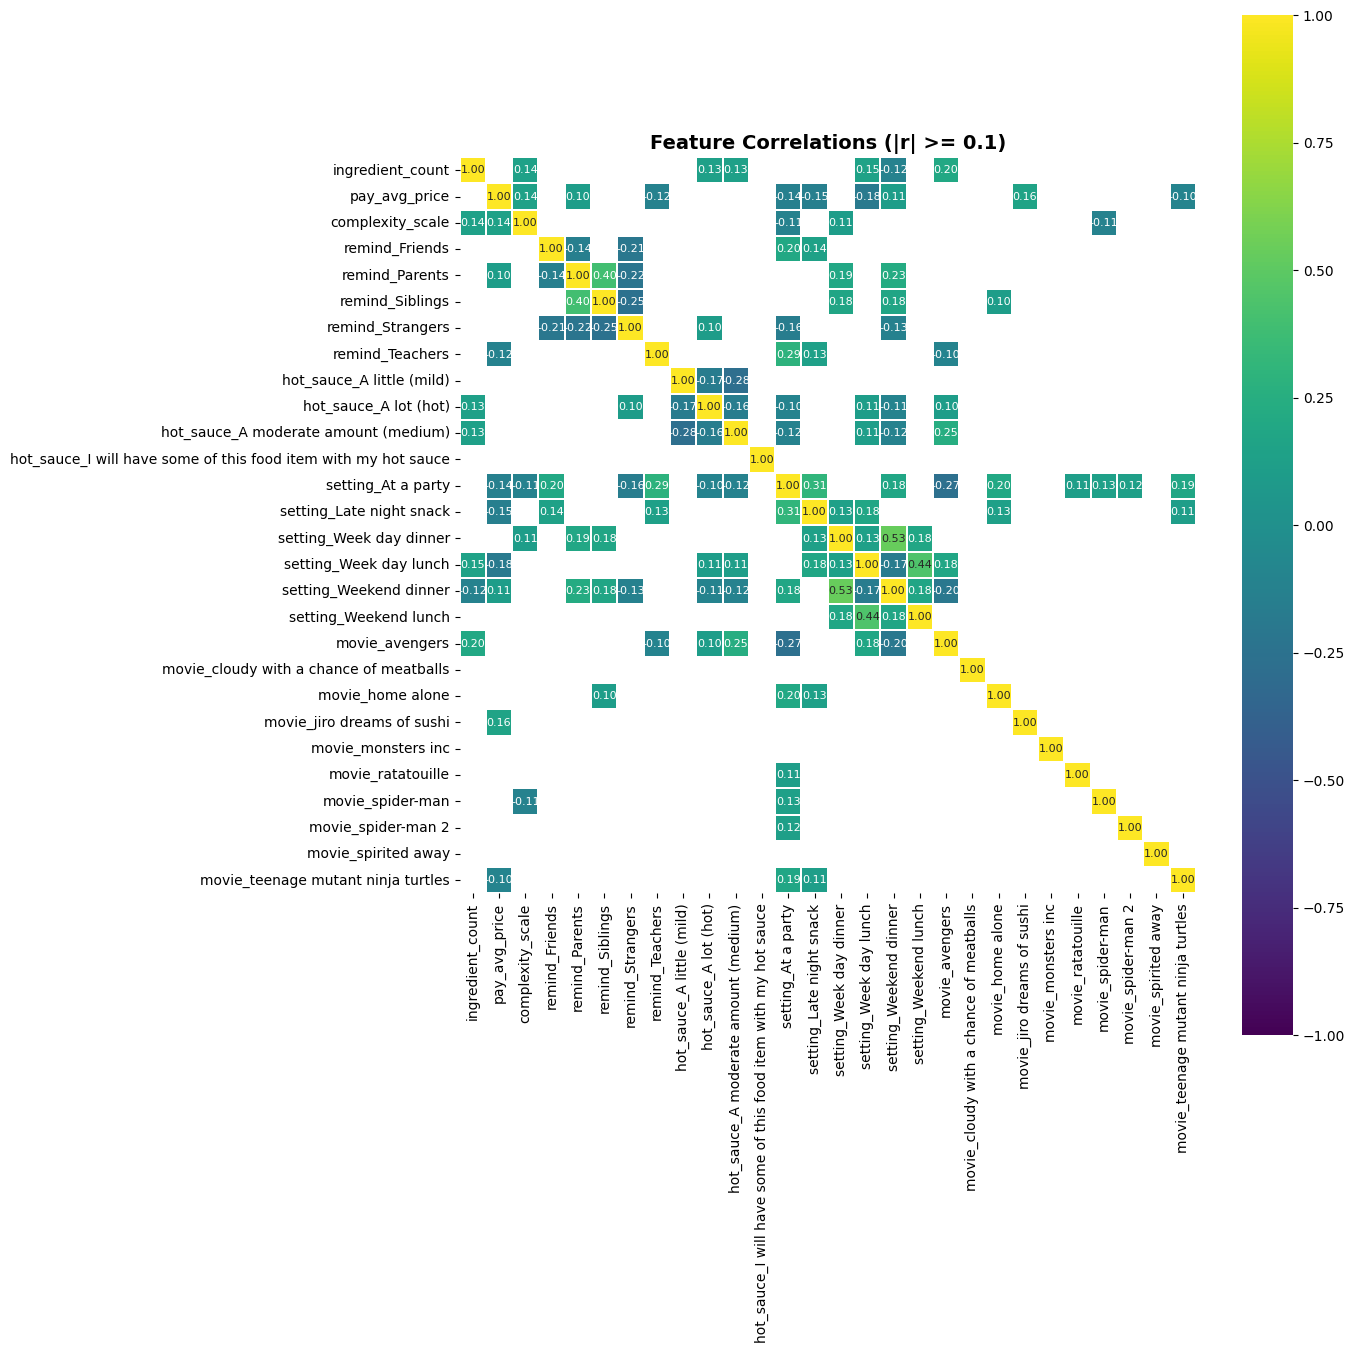

In [52]:


all_features = numerical_cols + remind_cols + hot_sauce_cols + setting_cols + movie_cols
corr = train_df[all_features].corr()

threshold = 0.1 

filtered_corr = corr[(corr >= threshold) | (corr <= -threshold)]
filtered_corr = filtered_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

print(f"Features with |r| >= {threshold}: {filtered_corr.shape[0]}")

if filtered_corr.shape[0] > 0:
    plt.figure(figsize=(max(12, filtered_corr.shape[0] * 0.5), 
                        max(10, filtered_corr.shape[1] * 0.5)))
    
    sns.heatmap(filtered_corr, 
                cmap='viridis', 
                vmax=1.0, 
                vmin=-1.0, 
                linewidths=0.1,
                annot=True, 
                annot_kws={"size": 8}, 
                square=True,
                fmt='.2f')
    
    plt.title(f'Feature Correlations (|r| >= {threshold})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"No correlations found with |r| >= {threshold}")
    print("Try an even lower threshold (e.g., 0.2)")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LOGISTIC REGRESSION COEFFICIENTS

Model Accuracy: 0.851
Classes: ['Pizza' 'Shawarma' 'Sushi']

TOP FEATURES FOR PIZZA

Top 30 features (positive = increases Pizza probability):
  At a party                               : +1.0767
  teenage mutant ninja turtles             : +0.7754
  home alone                               : +0.7148
  spider-man 2                             : +0.4518
  Teachers                                 : +0.4047
  jiro dreams of sushi                     : -0.3989
  Strangers                                : -0.3661
  Late night snack                         : +0.3108
  cloudy with a chance of meatballs        : +0.2980
  scale                                    : -0.2971
  spirited away                            : -0.2813
  Parents                                  : -0.2722
  spider-man                               : +0.2202
  sauce_A lot (hot)                        : -0.2183
  sauce_A moderate amount (medium)         : -0.2103
  Friends                   

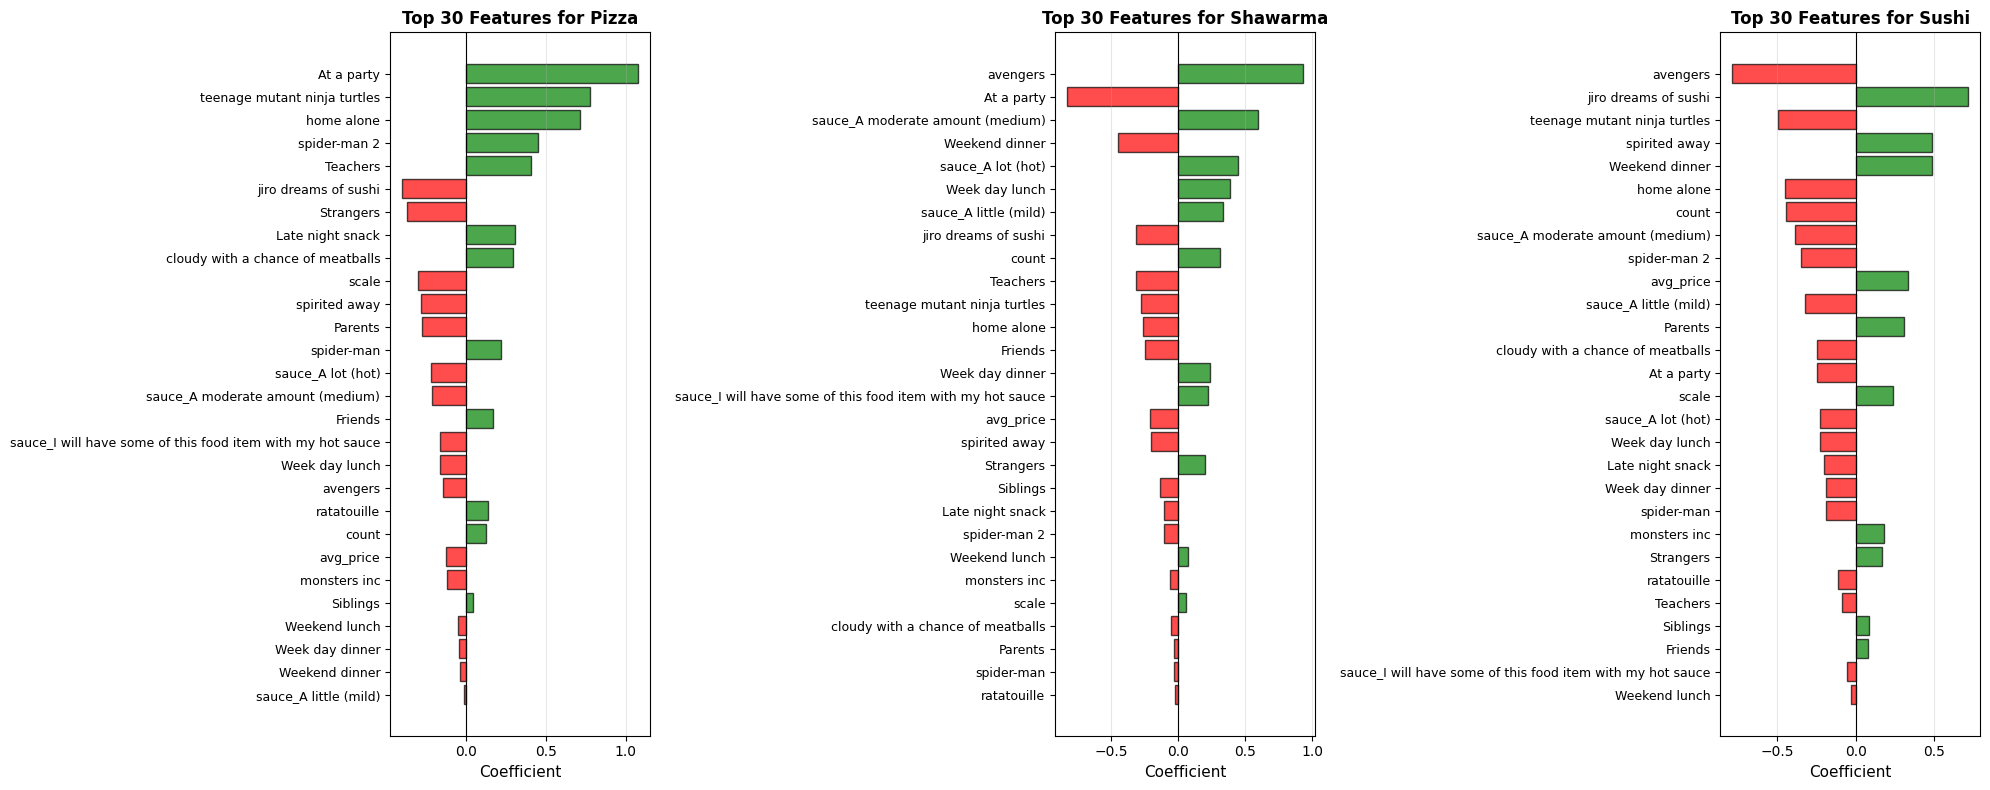

In [ ]:

def find_predictive_features(df, all_features, target_col='Food', top_n=20):

    X = df[all_features].copy()
    y = df[target_col]
    
    missing_count = X.isna().sum().sum()
    if missing_count > 0:
        X = X.fillna(0)

    
    # Standardize features 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Multinomial Logistic Regression
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
    lr.fit(X_scaled, y)
    
    # Get coefficients for each class
    # Shape: (n_classes, n_features)
    coefficients = lr.coef_
    
    print("="*70)
    print("LOGISTIC REGRESSION COEFFICIENTS")
    print("="*70)
    print(f"\nModel Accuracy: {lr.score(X_scaled, y):.3f}")
    print(f"Classes: {lr.classes_}")
    
    # Find top coefficients 
    for class_idx, class_name in enumerate(lr.classes_):
        print("\n" + "="*70)
        print(f"TOP FEATURES FOR {class_name.upper()}")
        print("="*70)
        
        # Get coefficients for this class
        class_coefs = coefficients[class_idx]
        
        # Create dataframe
        coef_df = pd.DataFrame({
            'Feature': all_features,
            'Coefficient': class_coefs,
            'Abs_Coefficient': np.abs(class_coefs)
        })
        
        # Sort by absolute value
        coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        print(f"\nTop {top_n} features (positive = increases {class_name} probability):")
        
        for idx, row in coef_df.head(top_n).iterrows():
            feature_clean = row['Feature'].split('_', 1)[1] if '_' in row['Feature'] else row['Feature']
            print(f"  {feature_clean:40s} : {row['Coefficient']:+.4f}")
    
    # Visualize coefficients
    fig, axes = plt.subplots(1, len(lr.classes_), figsize=(20, 8))
    
    for class_idx, class_name in enumerate(lr.classes_):
        class_coefs = coefficients[class_idx]
        
        # Get top features
        coef_df = pd.DataFrame({
            'Feature': all_features,
            'Coefficient': class_coefs
        }).sort_values('Coefficient', key=abs, ascending=False).head(top_n)
        
        # Clean names
        clean_names = [f.split('_', 1)[1] if '_' in f else f for f in coef_df['Feature']]
        
        # Colours
        colours = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
        
        axes[class_idx].barh(range(len(coef_df)), coef_df['Coefficient'], 
                            color=colours, alpha=0.7, edgecolor='black')
        axes[class_idx].set_yticks(range(len(coef_df)))
        axes[class_idx].set_yticklabels(clean_names, fontsize=9)
        axes[class_idx].set_xlabel('Coefficient', fontsize=11)
        axes[class_idx].set_title(f'Top {top_n} Features for {class_name}', 
                                  fontsize=12, fontweight='bold')
        axes[class_idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[class_idx].grid(True, alpha=0.3, axis='x')
        axes[class_idx].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    return lr, coefficients, scaler


lr_model, lr_coefs, scaler = find_predictive_features(train_df, all_features, target_col='Food', top_n=30)